In [ ]:

# Bibliothèque traitement de données et visualisation
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize

import os


In [ ]:
# Synchroniser Drive

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:


# Size des données de bases et de ground truth 
x_path = '/content/drive/MyDrive/Dataset_Hair/Training/'
y_path = '/content/drive/MyDrive/Dataset_Hair/Training_GT/'
x_paths = os.listdir(x_path)
y_paths = os.listdir(y_path)
print("Count X:",len(x_paths))
print("Count Y:",len(y_paths))


Count X: 840
Count Y: 854


In [ ]:
images,masks = [],[]
# Réperage des élements qui ne suivent pas la structure
size = min(len(x_paths),len(y_paths))
for i in range(size):
    file = x_paths[i].replace('-org.jpg','')
    img_path,mask_path = file + '-org.jpg', file + '-gt.pbm'
    if img_path in x_paths and mask_path in y_paths:
        images.append( io.imread(x_path + img_path,plugin='matplotlib',as_gray = True) )
        masks.append( io.imread(y_path + mask_path,plugin='matplotlib',as_gray = True))
print("Actual data size:",len(images),len(masks))

Actual data size: 840 840


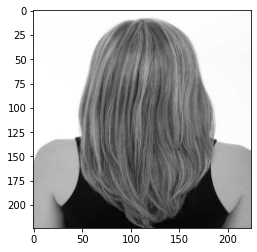

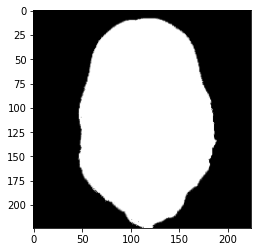

In [ ]:
# Un vecteur pour contenir les images

np_images = np.zeros((size,224,224,1))
np_masks = np.zeros((size,224,224,1))

# Normalisation des images pour avoir le même format 
for i in range(size):
    img = images[i]
    msk = masks[i]
    np_images[i] = resize(img,(224,224)).reshape((224,224,1))
    np_masks[i] = resize(msk,(224,224)).reshape((224,224,1))


In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models, metrics
from keras.layers import Input
import tensorflow as tf

In [5]:
inputs = Input((224, 224, 1))
# Conv - Conv => Extraire features de l'image , maxpool => réduire la taille de ces features maps
#fait 5 fois pour avoir le plus de features en augmentant le nombre de filters
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)


# In[ ]:

# Reconstruire l'image 
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)


In [3]:
# Initialiser le modèle 
# inputs = Input(tupple,[..]) 
'''
Input() is used to instantiate a Keras tensor.
A Keras tensor is a symbolic tensor-like object,
which we augment with certain attributes that allow us to build a Keras model just
by knowing the inputs and outputs of the model.
'''
model = Model(inputs=[inputs], outputs=[conv10])
'''
 Compilation avec comme adam comme Optimizer ( learning rate default d'adam est de 0.01)
 et fonction de côut mean square error, et on sauvegarde la métrique 
 Accuracy , Precision et Recall
 
'''
model.compile(optimizer='adam', loss='mse', metrics=['acc',metrics.Precision(), metrics.Recall()])
# On voit les couches du réseau
model.summary()

NameError: name 'Model' is not defined

In [ ]:
# Nombre d'epochs
epochs = 100
# Entrainement sur 80% de data et 20% de validation set
history = model.fit(np_images,np_masks,validation_split=0.2,epochs=epochs,batch_size=64,)


Epoch 1/50
13/13 [==============================] - 26s 1s/step - loss: 0.2857 - acc: 0.6176 - val_loss: 0.2226 - val_acc: 0.6655
Epoch 2/50
13/13 [==============================] - 12s 888ms/step - loss: 0.2058 - acc: 0.6462 - val_loss: 0.1747 - val_acc: 0.6785
Epoch 3/50
13/13 [==============================] - 11s 878ms/step - loss: 0.1699 - acc: 0.7005 - val_loss: 0.1543 - val_acc: 0.7111
Epoch 4/50
13/13 [==============================] - 11s 873ms/step - loss: 0.2781 - acc: 0.7062 - val_loss: 0.2705 - val_acc: 0.6655
Epoch 5/50
13/13 [==============================] - 11s 866ms/step - loss: 0.3356 - acc: 0.6128 - val_loss: 0.2639 - val_acc: 0.6655
Epoch 6/50
13/13 [==============================] - 11s 873ms/step - loss: 0.2866 - acc: 0.6293 - val_loss: 0.2317 - val_acc: 0.6314
Epoch 7/50
13/13 [==============================] - 11s 873ms/step - loss: 0.2218 - acc: 0.6285 - val_loss: 0.1720 - val_acc: 0.6985
Epoch 8/50
13/13 [==============================] - 11s 874ms/step - los

In [ ]:
# sauvegarde du model entrainé
model.save('/content/drive/MyDrive/Dataset_Hair/v2_Hairsegmentation_UNET.h5')

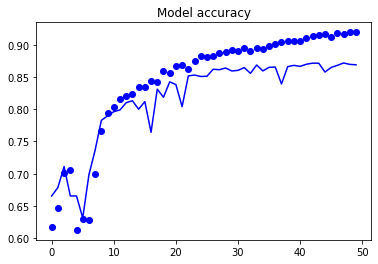

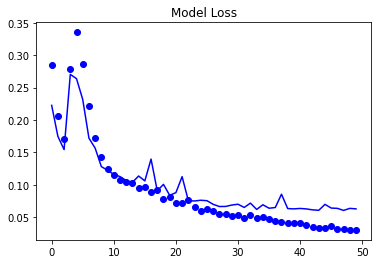

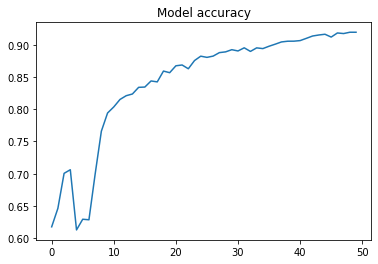

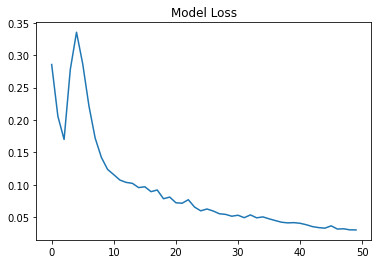

In [ ]:
h = history
plt.plot(h.history['acc'],'bo',label='Training acc')
plt.plot(h.history['val_acc'],'b',label='Validation acc')
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'],'bo',label='Training Loss')
plt.plot(h.history['val_loss'],'b',label='Validation Loss')
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'],)
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()


In [6]:
#  test sur un exemple de testing dataset 
idx = 11
img = np_images[idx]
real = np_masks[idx]

plt.imshow(img.reshape((224,224)),cmap='gray')
plt.show()
plt.imshow(real.reshape((224,224)),cmap='gray')
plt.show()
pred = model.predict(np.asarray([image]) ).reshape((224,224))


plt.imshow(pred,cmap='gray')
plt.show()




NameError: ignored

Mounted at /content/drive


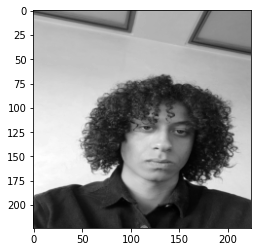

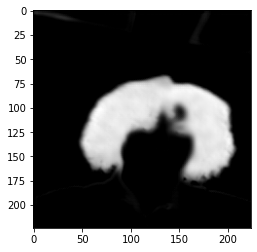

In [ ]:
# Inférence sur un exemple 
from tensorflow.keras import layers, models, metrics
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt



model_filename = '/content/drive/MyDrive/Dataset_Hair/v2_Hairsegmentation_UNET.h5'
#model_filename = 'gunshot_detection_model.h5'
model = models.load_model(model_filename)

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/drive/MyDrive/Dataset_Hair/test3.jpeg')

plt.imshow(image.reshape((224,224)),cmap='gray')
plt.show()


pred=model.predict(image)
plt.imshow(pred.reshape((224,224)),cmap='gray')
plt.show()